WERSJA 4.0

Instalacja niezbędnych bibliotek, załadowanie obrazów i wstępne ich przetworzenie (z wersji 3.0)

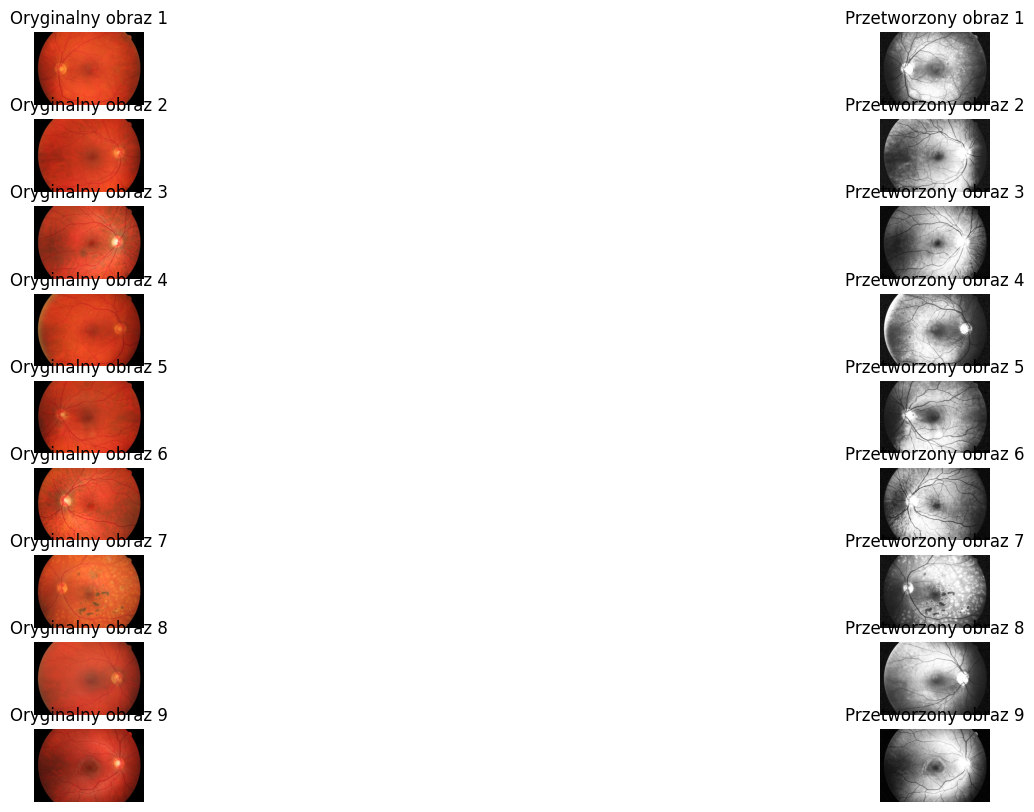

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, color, filters, exposure, img_as_float
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
import os
import sklearn
import skimage
from skimage import exposure, img_as_float
import cv2

# Ścieżki do folderów z obrazami i maskami
images_path = 'images'
manual_path = 'manual'
mask_path = 'mask'

# Funkcja do ładowania obrazów
def load_images(path, filenames):
    images = []
    for filename in filenames:
        img = io.imread(os.path.join(path, filename))
        images.append(img)
    return images

# Ładowanie obrazów i masek
images = load_images(images_path, ['01_dr.jpg', '01_g.jpg', '01_h.jpg', '02_dr.jpg', '02_g.jpg', '02_h.jpg', '03_dr.jpg', '03_g.jpg', '13_h.jpg'])
masks = load_images(manual_path, ['01_dr.tiff', '01_g.tiff', '01_h.tiff', '02_dr.tiff', '02_g.tiff', '02_h.tiff', '03_dr.tiff', '03_g.tiff', '13_h.tiff'])
circle_masks = load_images(mask_path, ['01_dr_mask.tiff', '01_g_mask.tiff', '02_dr_mask.tiff', '02_g_mask.tiff', '02_h_mask.tiff', '03_dr_mask.tiff', '03_g_mask.tiff', '13_h_mask.tiff'])

# Funkcja do wstępnego przetwarzania obrazu
def preprocess_image(image):
    gray_image = color.rgb2gray(image)
    gray_image = img_as_float(gray_image)
    image_eq = exposure.equalize_hist(gray_image)
    return image_eq

# Przetwarzanie obrazów
preprocessed_images = [preprocess_image(image) for image in images]

# Funkcja do wyświetlania obrazów i przetworzonych wersji
def display_preprocessed_images(original_images, preprocessed_images):
    num_images = len(original_images)
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(num_images, 2, i * 2 + 1)
        plt.title(f'Oryginalny obraz {i+1}')
        plt.imshow(original_images[i])
        plt.axis('off')

        plt.subplot(num_images, 2, i * 2 + 2)
        plt.title(f'Przetworzony obraz {i+1}')
        plt.imshow(preprocessed_images[i], cmap='gray')
        plt.axis('off')
    plt.show()

# Wyświetlenie obrazów po wstępnym przetwarzaniu
display_preprocessed_images(images, preprocessed_images)

Podział obrazów na wycinki (5x5 px) i ekstrakcja cech

In [86]:
from skimage.measure import moments, moments_hu, moments_central

# Funkcja do podziału obrazu na wycinki
def extract_patches(image, mask, circle_mask, patch_size=5):
    half_patch = patch_size // 2
    patches = []
    labels = []
    used_indices = []
    for i in range(half_patch, image.shape[0] - half_patch):
        for j in range(half_patch, image.shape[1] - half_patch):
          if not np.all(circle_mask[i, j] > 200):
            continue
          else:
            patch = image[i-half_patch:i+half_patch+1, j-half_patch:j+half_patch+1]
            label = mask[i, j]
            patches.append(patch)
            labels.append(label)
            used_indices.append((i, j))
    return np.array(patches), np.array(labels), used_indices

# Funkcja do ekstrakcji cech z wycinka
def extract_features(patch):
    features = []
    features.append(np.var(patch))
    mc = moments_central(patch)
    mh = moments_hu(mc)
    features.extend(mh)
    return np.array(features)

# Funkcja do przygotowania zbioru danych
def prepare_dataset(images, masks, circle_masks, patch_size=5):
    all_features = []
    all_labels = []
    all_used_indices = []
    for image, mask, circle_mask in zip(images, masks, circle_masks):
        patches, labels, used_indices = extract_patches(image, mask, circle_mask, patch_size)
        features = np.array([extract_features(patch) for patch in patches])
        labels = (labels > 0).astype(int)
        all_features.append(features)
        all_labels.append(labels)
        all_used_indices.append(used_indices)
    return np.vstack(all_features), np.hstack(all_labels), all_used_indices

# Funkcja do przygotowania zbioru danych dla jednego obrazu
def prepare_single_image_dataset(image, mask, circle_mask, patch_size=5):
    patches, labels, used_indices = extract_patches(image, mask, circle_mask, patch_size)
    features = np.array([extract_features(patch) for patch in patches])
    labels = (labels > 0).astype(int)
    return features, labels, used_indices

train_images = preprocessed_images[:3]
train_masks = masks[:3]
train_circle_masks = circle_masks[:3]
test_images = preprocessed_images[3:]
test_masks = masks[3:]
test_circle_masks = circle_masks[3:]

# Przygotowanie zbiorów danych
train_features, train_labels, _ = prepare_dataset(train_images, train_masks, train_circle_masks)
test_features, test_labels, test_used_indices = prepare_dataset(test_images, test_masks, test_circle_masks)


# Wyświetlenie kształtu przygotowanych danych
print("Train features shape:", train_features.shape)
print("Train labels shape:", train_labels.shape)
print("Test features shape:", test_features.shape)
print("Test labels shape:", test_labels.shape)

Train features shape: (417552, 8)
Train labels shape: (417552,)
Test features shape: (696546, 8)
Test labels shape: (696546,)


Budowa, trenowanie i weryfikacja klasyfikatora

In [87]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler

# Podział danych na zbiór uczący i testowy
X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.3, random_state=100, stratify=train_labels)

# Wyrównanie rozkładu klas w zbiorze uczącym
undersampler = RandomUnderSampler(random_state=100)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Tworzenie i trenowanie modelu drzewa decyzyjnego
clf = DecisionTreeClassifier(random_state=100)
clf.fit(X_train_resampled, y_train_resampled)

# Predykcja i wizualizacja dla każdego obrazu testowego
predictions = []
for test_image, test_mask, test_circle_mask, used_indices in zip(test_images, test_masks, test_circle_masks, test_used_indices):
    test_features, _, used_indices = prepare_single_image_dataset(test_image, test_mask, test_circle_mask)
    y_test_pred = clf.predict(test_features)
    predictions.append((test_image, test_mask, y_test_pred, used_indices))

# Wyznaczanie metryk jakości działania modelu na całym zbiorze testowym
y_test_pred_all = np.concatenate([pred for _, _, pred, _ in predictions])
accuracy = accuracy_score(test_labels, y_test_pred_all)
recall = recall_score(test_labels, y_test_pred_all)
precision = precision_score(test_labels, y_test_pred_all)
conf_matrix = confusion_matrix(test_labels, y_test_pred_all)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.6190789983719668
Recall: 0.5864166039489436
Precision: 0.3875765324858286
Confusion Matrix:
 [[315120 183449]
 [ 81880 116097]]


Wizualizacja wyników

In [88]:
import matplotlib.pyplot as plt

# Funkcja do przygotowania zbioru danych dla jednego obrazu
def prepare_single_image_dataset(image, mask, circle_mask, patch_size=5):
    patches, labels, used_indices = extract_patches(image, mask, circle_mask, patch_size)
    features = np.array([extract_features(patch) for patch in patches])
    labels = (labels > 0).astype(int)
    return features, labels, used_indices


# Funkcja do generowania binarnej maski predykcji
def generate_prediction_mask(image_shape, predictions, used_indices, patch_size=5):
    half_patch = patch_size // 2
    prediction_mask = np.zeros(image_shape)
    for (i, j), pred in zip(used_indices, predictions):
        prediction_mask[i, j] = pred
    return prediction_mask

# Funkcja do wyświetlania obrazów
def display_results(original_image, expert_mask, prediction_mask):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title('Oryginalny obraz')
    plt.imshow(original_image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Maska ekspercka')
    plt.imshow(expert_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Maska predykcji')
    plt.imshow(prediction_mask, cmap='gray')
    plt.axis('off')

    plt.show()

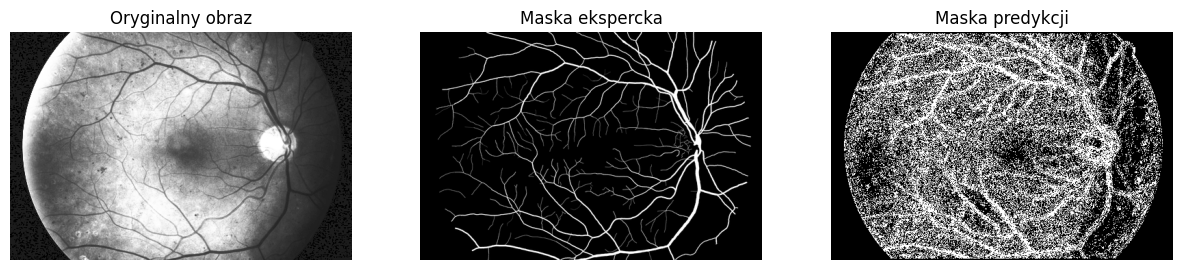

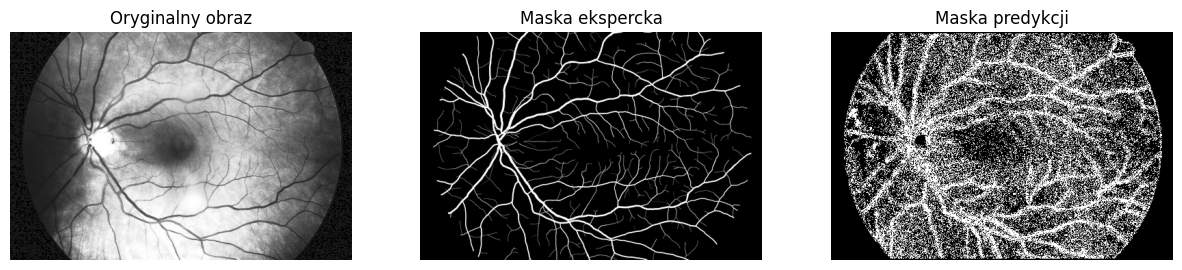

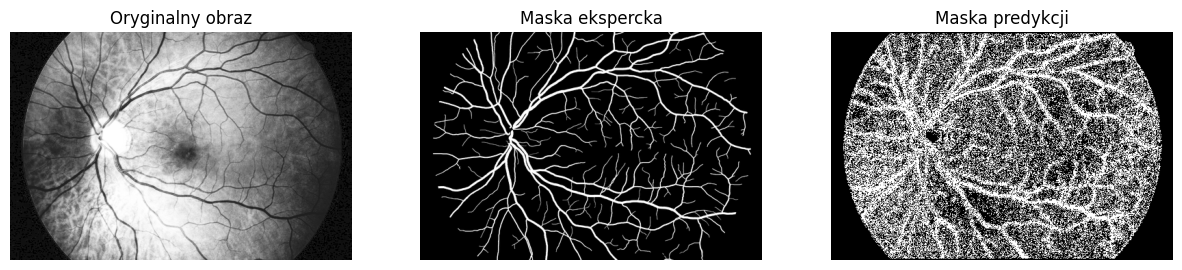

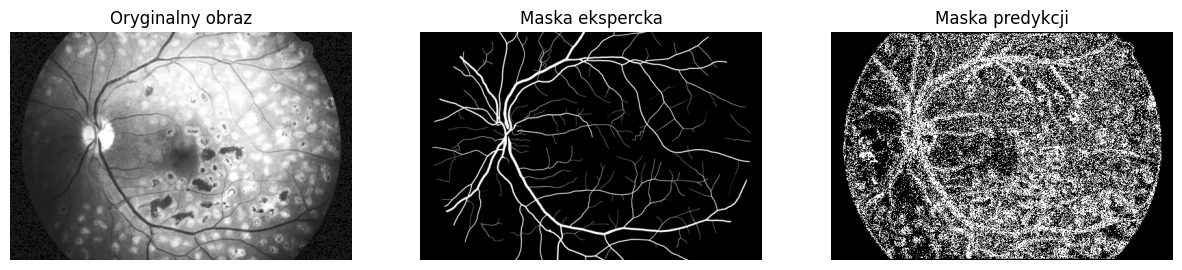

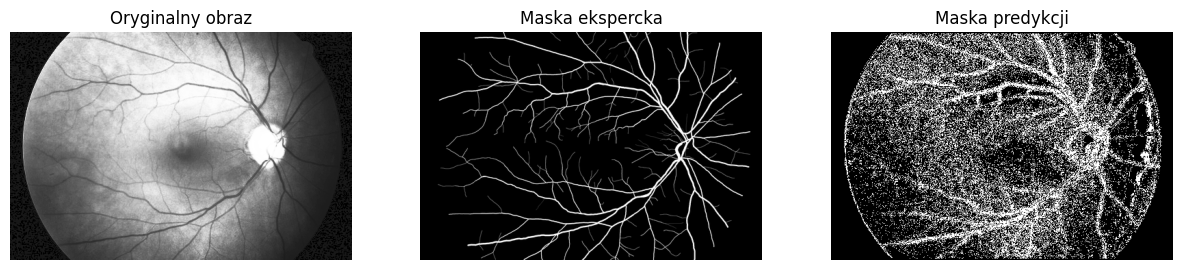

In [89]:
for test_image, test_mask, y_test_pred, used_indices in predictions:
    test_prediction_mask = generate_prediction_mask(test_image.shape, y_test_pred, used_indices)
    display_results(test_image, test_mask, test_prediction_mask)